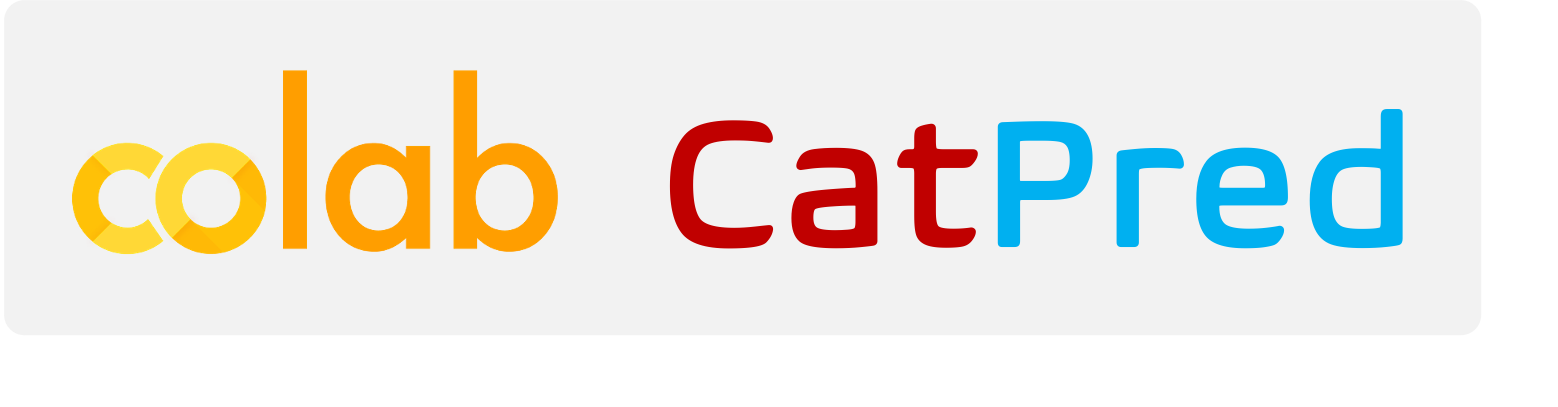
# CatPred: Prediction of Enzyme-Substrate $k_{cat}$, $K_{m}$ and Enzyme-Inhibitor $K_{i}$

```markdown
This notebook runs the CatPred models for enzyme kinetic parameter prediction. The pipeline processes enzyme sequences into the ESM2 language model encodings and reactant SMILES strings into 2d graphs and inputs to the pretrained CatPred models. Output from CatPred is the kinetic parameter prediction along with the attached prediction uncertainities.

By default, the notebook runs on an example enzyme sequence and substrate, edit them to your own inputs and "Run" each cell by clicking the ▶ icon to the left of each cell
```
---
**Inputs**
1. Enzyme sequence - the aminoacid sequence of the enzyme (in capital letters with no spaces)
2. Substrate/Inhibitor canonical SMILES string for $K_{m}$ and $K_{i}$<br>
(OR)<br>
Concatenated SMILES string of all reactants for $k_{cat}$. Use "." character for concatenation.
---
**Outputs**

$k_{cat}$ or $K_{m}$ or $K_{i}$ prediction and their estimated standard deviation values. <br>

---

More information is available on https://github.com/maranasgroup/catpred/

## CatPred: Setup (~15 mins)

In [1]:
#@title Install CatPred and download trained models (~10 min)

!wget -c https://repo.anaconda.com/archive/Anaconda3-2024.10-1-Linux-x86_64.sh
!chmod +x Anaconda3-2024.10-1-Linux-x86_64.sh
!bash ./Anaconda3-2024.10-1-Linux-x86_64.sh -b -f -p /usr/local

!wget https://catpred.s3.us-east-1.amazonaws.com/pretrained_production.tar.gz -q
!tar -xzf pretrained_production.tar.gz
!wget https://catpred.s3.amazonaws.com/processed_databases.tar.gz -q
!tar -xzf processed_databases.tar.gz

!git clone https://github.com/maranasgroup/catpred.git && cd catpred && git checkout 9d57732

%cd catpred/
!conda env create -f ./environment.yml -q
!source activate catpred;pip install -e . -q
!chmod +x predict.sh

import sys
sys.path.append('/usr/local/envs/catpred/lib/python3.9/site-packages')

--2026-02-27 20:56:57--  https://repo.anaconda.com/archive/Anaconda3-2024.10-1-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1102495056 (1.0G) [application/octet-stream]
Saving to: ‘Anaconda3-2024.10-1-Linux-x86_64.sh’

Anaconda3-2024.10-1 100%[===================>]   1.03G  89.8MB/s    in 12s     

2026-02-27 20:57:09 (86.2 MB/s) - ‘Anaconda3-2024.10-1-Linux-x86_64.sh’ saved [1102495056/1102495056]

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Anaconda3.
    For best results, please verify that your P

In [2]:
#@title Load processed BRENDA database

import pandas as pd
import numpy as np
from rdkit import Chem
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Disable RDKit logging
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def run_once(func):
    def wrapper(*args, **kwargs):
        if not wrapper.has_run:
            wrapper.result = func(*args, **kwargs)
            wrapper.has_run = True
        return wrapper.result
    wrapper.has_run = False
    return wrapper

@run_once
def load_brenda_data(file_path: str) -> pd.DataFrame:
    """
    Load the BRENDA database from a CSV file.

    Args:
        file_path (str): Path to the BRENDA CSV file.

    Returns:
        pd.DataFrame: The loaded BRENDA database.
    """
    return pd.read_csv(file_path)

def preprocess_reaction_smiles(reaction_smiles: str) -> str:
    """
    Preprocess a reaction SMILES string by splitting it into reactants,
    sorting them, and canonicalizing them using RDKit.

    Args:
        reaction_smiles (str): The reaction SMILES string.

    Returns:
        str: The preprocessed reactant SMILES string.
    """
    if not pd.isna(reaction_smiles):
        reactants = reaction_smiles.split('>>')[0]
        if '.' in reactants:
            reactant_list = reactants.split('.')
            reactant_list = sorted(reactant_list)
            canonicalized_reactants = []
            for reactant in reactant_list:
                try:
                    mol = Chem.MolFromSmiles(reactant)
                    canonicalized_reactants.append(Chem.MolToSmiles(mol, isomericSmiles=False))
                except:
                    canonicalized_reactants.append(reactant)
            reactants = '.'.join(canonicalized_reactants)
        return reactants
    else:
        return 'None'

@run_once
def create_input_strings_brenda(brenda_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create input strings for kcat and kmki predictions.

    Args:
        brenda_df (pd.DataFrame): The BRENDA database.

    Returns:
        pd.DataFrame: The BRENDA database with input strings.
    """
    brenda_df['reactant_smiles'] = brenda_df['reaction_smiles'].apply(preprocess_reaction_smiles)
    brenda_df['input_str_kcat'] = brenda_df['sequence'] + np.array(['__']*len(brenda_df)) + brenda_df['reactant_smiles']
    brenda_df['input_str_kmki'] = brenda_df['sequence'] + np.array(['__']*len(brenda_df)) + brenda_df['substrate_smiles']
    return brenda_df

def find_matches_brenda(brenda_df: pd.DataFrame, input_smi: str, seq: str, parameter: str) -> pd.DataFrame:
    """
    Find matches in the BRENDA database for a given input SMILES string and sequence.

    Args:
        brenda_df (pd.DataFrame): The BRENDA database.
        input_smi (str): The input SMILES string.
        seq (str): The sequence.
        parameter (str): The parameter to search for (kcat, km, or ki).

    Returns:
        pd.DataFrame: The matched rows from the BRENDA database.
    """
    input_smi = preprocess_reaction_smiles(input_smi)
    input_str = seq + '__' + input_smi
    if parameter == 'kcat':
        input_header = 'input_str_kcat'
        label_header = 'turnover_number'
    else:
        input_header = 'input_str_kmki'
        if parameter == 'km':
            label_header = 'km_value'
        else:
            label_header = 'ki_value'
    matched = brenda_df[brenda_df[input_header] == input_str]
    matched_values = matched[matched['parameter'] == label_header]
    return matched_values

def find_matches_brenda_seq(brenda_df: pd.DataFrame, seq: str) -> pd.DataFrame:
    """
    Find matches in the BRENDA database for a given input SMILES string and sequence.

    Args:
        brenda_df (pd.DataFrame): The BRENDA database.
        seq (str): The sequence.

    Returns:
        pd.DataFrame: The matched rows from the BRENDA database.
    """
    input_str = seq
    label_header = 'turnover_number'
    matched = brenda_df[brenda_df['sequence'] == input_str]
    matched_values = matched[matched['parameter'] == label_header]

    return matched_values

def display_matches_brenda(matched_values: pd.DataFrame, parameter: str) -> None:
    """
    Display the matched rows from the BRENDA database.

    Args:
        matched_values (pd.DataFrame): The matched rows.
        parameter (str): The parameter to display (kcat, km, or ki).
    """
    display_cols_brenda = ['organism', 'ec', 'substrate', 'parameter', 'value', 'ph', 'temperature', 'comment']
    if parameter.lower() == 'kcat':
        display_cols_brenda.append('reaction_smiles')
    elif parameter.lower() == 'km' or parameter.lower() == 'ki':
        display_cols_brenda.append('substrate_smiles')

    print(f'Found {len(matched_values)} occurrences of input in BRENDA:')
    if len(matched_values) > 0:
        display(matched_values[display_cols_brenda])

# Load the BRENDA database
brenda_df = load_brenda_data('../processed_databases/brenda.csv')

# Create input strings
brenda_df = create_input_strings_brenda(brenda_df)

In [3]:
#@title Load processed SABIO-RK database


import pandas as pd
import numpy as np
from rdkit import Chem
from google.colab import data_table
data_table.enable_dataframe_formatter()

def run_once(func):
    def wrapper(*args, **kwargs):
        if not wrapper.has_run:
            wrapper.result = func(*args, **kwargs)
            wrapper.has_run = True
        return wrapper.result
    wrapper.has_run = False
    return wrapper

@run_once
def load_sabio_data(file_path: str) -> pd.DataFrame:
    """
    Load the SABIO-RK database from a CSV file.

    Args:
        file_path (str): Path to the SABIO-RK CSV file.

    Returns:
        pd.DataFrame: The loaded SABIO-RK database.
    """
    return pd.read_csv(file_path, low_memory=False)


@run_once
def create_input_strings_sabio(sabio_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create input strings for kcat and kmki predictions.

    Args:
        sabio_df (pd.DataFrame): The SABIO-RK database.

    Returns:
        pd.DataFrame: The SABIO-RK database with input strings.
    """
    sabio_df['reactant_smiles'] = sabio_df['reaction_smiles'].apply(preprocess_reaction_smiles)
    sabio_df['input_str_kcat'] = sabio_df['sequence'] + np.array(['__']*len(sabio_df)) + sabio_df['reactant_smiles']
    sabio_df['input_str_kmki'] = sabio_df['sequence'] + np.array(['__']*len(sabio_df)) + sabio_df['param_species_smiles']
    return sabio_df


def find_matches_sabio(sabio_df: pd.DataFrame, input_smi: str, seq: str, parameter: str) -> pd.DataFrame:
    """
    Find matches in the SABIO-RK database for a given input SMILES string and sequence.

    Args:
        sabio_df (pd.DataFrame): The SABIO-RK database.
        input_smi (str): The input SMILES string.
        seq (str): The sequence.
        parameter (str): The parameter to search for (kcat, km, or ki).

    Returns:
        pd.DataFrame: The matched rows from the SABIO-RK database.
    """
    input_smi = preprocess_reaction_smiles(input_smi)
    input_str = seq + '__' + input_smi
    if parameter == 'kcat':
        input_header = 'input_str_kcat'
        label_header = 'kcat'
    else:
        input_header = 'input_str_kmki'
        if parameter == 'km':
            label_header = 'Km'
        else:
            label_header = 'Ki'
    matched = sabio_df[sabio_df[input_header] == input_str]
    matched_values = matched[matched['param_name'] == label_header]
    return matched_values

def display_matches_sabio(matched_values: pd.DataFrame, parameter: str) -> None:
    """
    Display the matched rows from the SABIO-RK database.

    Args:
        matched_values (pd.DataFrame): The matched rows.
        parameter (str): The parameter to display (kcat, km, or ki).
    """
    display_cols_sabio = ['species', 'ec', 'param_species_name', 'param_name', 'param_value', 'ph', 'temperature', 'pubmed_id']
    if parameter.lower() == 'kcat':
        display_cols_sabio.append('reaction_smiles')
    elif parameter.lower() == 'km' or parameter.lower() == 'ki':
        display_cols_sabio.append('param_species_smiles')

    print(f'Found {len(matched_values)} occurrences of input in SABIO-RK:')
    if len(matched_values) > 0:
        display(matched_values[display_cols_sabio])

# Load the SABIO-RK database
sabio_df = load_sabio_data('../processed_databases/sabio.csv')

# Create input strings
sabio_df = create_input_strings_sabio(sabio_df)

## CatPred: $k_{cat}$ example

Input success!
Enzyme sequence length: 465
Substrate structure:


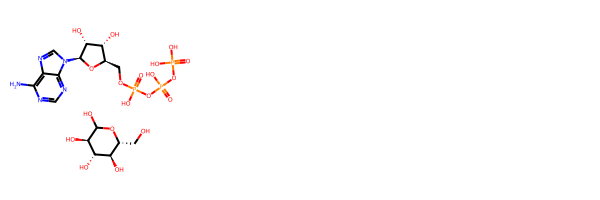

Predicting.. This will take a minute or so..

Prediction successful!

Result:



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
#@title Get prediction:
# prediction_type = "kcat" #@param ["kcat", "Km", "Ki"]
parameter = 'kcat' # @param ["kcat", "Km", "Ki"] {allow-input: true}
parameter = parameter.lower()

import os
import time
import pandas as pd
import numpy as np
from IPython.display import Image, display, Math
from rdkit import Chem
from rdkit.Chem.Draw.IPythonConsole import ShowMols

uniprot_id = "P35557" #@param {type:"string"}
#@markdown If you do not have a uniprot-id, enter some name (for eg: "enzyme1")
sequence = 'MLDDRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ' #@param {type:"string"}
SMILES = "C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O.C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O)O)N " #@param {type:"string"}

def create_csv_sh(parameter, uni, seq, smi):
    """
    Create input CSV and shell script for prediction.

    Args:
        parameter (str): Kinetics parameter to predict.
        uni (str): UniProt ID or enzyme name.
        seq (str): Enzyme sequence.
        smi (str): Substrate SMILES.

    Returns:
        tuple: Enzyme sequence and SMILES if successful, None otherwise.
    """
    try:
        mol = Chem.MolFromSmiles(smi)
        smi = Chem.MolToSmiles(mol)
    except:
        print('Invalid SMILES input!')
        print('Correct your input! Exiting..')
        return None

    # Validate enzyme sequence
    valid_aas = set('ACDEFGHIKLMNPQRSTVWY')
    if not set(seq).issubset(valid_aas):
        print('Invalid Enzyme sequence input!')
        print('Correct your input! Exiting..')
        return None

    # Sort SMILES components for kcat prediction
    if parameter == 'kcat' and '.' in smi:
        smi = '.'.join(sorted(smi.split('.')))

    # Create input CSV
    with open(f'{uni}_{parameter}_input.csv', 'w') as f:
        f.write('name,sequence,SMILES,pdbpath\n')
        f.write(f'{uni},{seq},{smi},{uni}.pdb\n')

    # Create prediction shell script
    with open('predict.sh', 'w') as f:
        f.write(f'''
TEST_FILE_PREFIX={uni}_{parameter}
RECORDS_FILE=${{TEST_FILE_PREFIX}}.json.gz
CHECKPOINT_DIR=../pretrained/production/{parameter}/

python ./scripts/create_pdbrecords.py --data_file ${{TEST_FILE_PREFIX}}_input.csv --out_file ${{RECORDS_FILE}}
python predict.py --test_path ${{TEST_FILE_PREFIX}}_input.csv --preds_path ${{TEST_FILE_PREFIX}}_output.csv --checkpoint_dir $CHECKPOINT_DIR --uncertainty_method mve --smiles_column SMILES --individual_ensemble_predictions --protein_records_path $RECORDS_FILE
''')

    print('Input success!')
    print('Enzyme sequence length:', len(sequence))
    print('Substrate structure:')
    display(ShowMols([mol]))

    return seq, smi

def get_predictions(parameter, uniprot_id):
    """
    Process and display prediction results.

    Args:
        parameter (str): Kinetics parameter that was predicted.
        uniprot_id (str): UniProt ID or enzyme name used in prediction.
    """
    df = pd.read_csv(f'{uniprot_id}_{parameter}_output.csv')

    # Set parameter-specific variables
    if parameter == 'kcat':
        parameter_print, parameter_print_log = 'k_{cat}', 'log_{10}(k_{cat})'
        target_col, unit = 'log10kcat_max', ' s^{-1}'
    elif parameter == 'km':
        parameter_print, parameter_print_log = 'K_{m}', 'log_{10}(K_{m})'
        target_col, unit = 'log10km_mean', ' mM'
    else:
        parameter_print, parameter_print_log = 'K_{i}', 'log_{10}(K_{i})'
        target_col, unit = 'log10ki_mean', ' mM'

    unc_col = f'{target_col}_mve_uncal_var'
    model_cols = [col for col in df.columns if col.startswith(target_col) and 'model_' in col]

    # Extract predictions and calculate uncertainties
    unc = df[unc_col].iloc[0]
    prediction = df[target_col].iloc[0]
    prediction_linear = np.power(10, prediction)
    model_outs = np.array([df[col].iloc[0] for col in model_cols])
    epi_unc = np.var(model_outs)
    alea_unc = unc - epi_unc
    epi_unc, alea_unc, unc = np.sqrt(epi_unc), np.sqrt(alea_unc), np.sqrt(unc)

    # Display results
    print('Result:\n')
    display(Math((parameter_print + f' = {prediction_linear:.5f}'+ unit)))
    print('\n')
    display(Math((parameter_print_log + f' = {prediction:.5f}')))
    display(Math(('SD_{total}'+f' = {unc:.5f}')))
    display(Math(('SD_{aleatoric}'+f' = {alea_unc:.5f}')))
    display(Math(('SD_{epistemic}'+f' = {epi_unc:.5f}')))

# Main execution
seq, smi = create_csv_sh(parameter, uniprot_id, sequence, SMILES)

import subprocess

if seq and smi:
    print('Predicting.. This will take a minute or so..\n')
    try:
        # Use subprocess to activate the environment and run the script
        command = (
            "source activate catpred && "
            "export PROTEIN_EMBED_USE_CPU=1 && "
            "chmod +x ./predict.sh && "
            "./predict.sh"
        )
        status = subprocess.call(command, shell=True, executable="/bin/bash")
        if status == 0:
            print('Prediction successful!\n')
            get_predictions(parameter, uniprot_id)
        else:
            print('Prediction failed!')
    except Exception as e:
        print(f"An error occurred: {e}")

In [8]:
#@title Get BRENDA matches

# Find matches
input_smi = preprocess_reaction_smiles(smi)
seq = seq
parameter = parameter
matched_values = find_matches_brenda(brenda_df, input_smi, seq, parameter)

# Display matches
display_matches_brenda(matched_values, parameter)

Found 3 occurrences of input in BRENDA:


,organism,ec,substrate,parameter,value,ph,temperature,comment,reaction_smiles
32800,Homo sapiens,2.7.1.1,D-glucose,turnover_number,40.1,8.6,33.0,"#87# wild-type, pH 7.6, 25 °C <240>",C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...
32801,Homo sapiens,2.7.1.1,D-glucose,turnover_number,60.4,7.4,37.0,"#87# wild type enzyme, in 25 mM HEPES (pH 7.4)...",C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...
32802,Homo sapiens,2.7.1.1,D-glucose,turnover_number,62.8,8.6,33.0,"#87# pH 7.1, temperature not specified in the ...",C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...


In [9]:
#@title Get SABIO-RK matches

# Find matches
input_smi = preprocess_reaction_smiles(smi)
seq = seq
parameter = parameter
matched_values = find_matches_sabio(sabio_df, input_smi, seq, parameter)

# Display matches
display_matches_sabio(matched_values, parameter)

Found 15 occurrences of input in SABIO-RK:


,species,ec,param_species_name,param_name,param_value,ph,temperature,pubmed_id,reaction_smiles
25241,Homo sapiens,2.7.1.2,NaN,kcat,66.4,7.5,30.0,7742312.0,OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...
25250,Homo sapiens,2.7.1.2,NaN,kcat,56.4,7.5,30.0,7742312.0,OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...
25255,Homo sapiens,2.7.1.2,N-Acetyl-D-glucosamine,kcat,66.4,7.5,30.0,7742312.0,OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...
25259,Homo sapiens,2.7.1.2,alpha-D-Mannoheptulopyranose,kcat,66.4,7.5,30.0,7742312.0,OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...
25270,Homo sapiens,2.7.1.2,ATP,kcat,62.3,7.4,30.0,15677479.0,OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...
25272,Homo sapiens,2.7.1.2,ATP,kcat,62.3,7.4,30.0,15677479.0,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...
25274,Homo sapiens,2.7.1.2,D-Glucose,kcat,66.7,NaN,30.0,7961659.0,OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...
25276,Homo sapiens,2.7.1.2,D-Glucose,kcat,56.0,7.5,30.0,7961659.0,OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...
25282,Homo sapiens,2.7.1.2,D-Glucosamine,kcat,66.4,NaN,30.0,7961659.0,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...
25287,Homo sapiens,2.7.1.2,D-Glucose,kcat,66.4,NaN,30.0,7961659.0,OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...


## CatPred: $K_{m}$ example

Input success!
Enzyme sequence length: 465
Substrate structure:


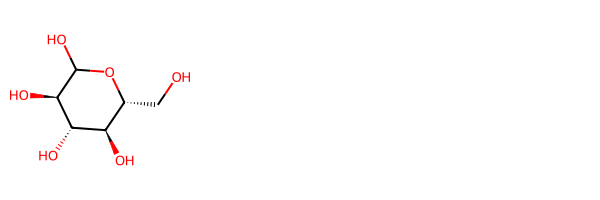

Predicting.. This will take a minute or so..

Prediction successful!

Result:



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
#@title Get prediction:
# prediction_type = "kcat" #@param ["kcat", "Km", "Ki"]
parameter = 'Km' # @param ["kcat", "Km", "Ki"] {allow-input: true}
parameter = parameter.lower()

uniprot_id = "P35557" #@param {type:"string"}
#@markdown If you do not have a uniprot-id, enter some name (for eg: "enzyme1")
sequence = 'MLDDRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ' #@param {type:"string"}
SMILES = "C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O" #@param {type:"string"}

# Main execution
seq, smi = create_csv_sh(parameter, uniprot_id, sequence, SMILES)

import subprocess

if seq and smi:
    print('Predicting.. This will take a minute or so..\n')
    try:
        # Use subprocess to activate the environment and run the script
        command = (
            "source activate catpred && "
            "export PROTEIN_EMBED_USE_CPU=1 && "
            "chmod +x ./predict.sh && "
            "./predict.sh"
        )
        status = subprocess.call(command, shell=True, executable="/bin/bash")
        if status == 0:
            print('Prediction successful!\n')
            get_predictions(parameter, uniprot_id)
        else:
            print('Prediction failed!')
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
#@title Get BRENDA matches

# Find matches
input_smi = preprocess_reaction_smiles(smi)
seq = seq
parameter = parameter
matched_values = find_matches_brenda(brenda_df, input_smi, seq, parameter)

# Display matches
display_matches_brenda(matched_values, parameter)

Found 1 occurrences of input in BRENDA:


,organism,ec,substrate,parameter,value,ph,temperature,comment,substrate_smiles
32699,Homo sapiens,2.7.1.1,D-glucose,km_value,6.3,8.6,33.0,"#87# wild-type, K0.5 value, Hill coefficient 1...",OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O


In [ ]:
#@title Get SABIO-RK matches

# Find matches
input_smi = preprocess_reaction_smiles(smi)
seq = seq
parameter = parameter
matched_values = find_matches_sabio(sabio_df, input_smi, seq, parameter)

# Display matches
display_matches_sabio(matched_values, parameter)

Found 0 occurrences of input in SABIO-RK:


## CatPred: $K_{i}$ example

Input success!
Enzyme sequence length: 485
Substrate structure:


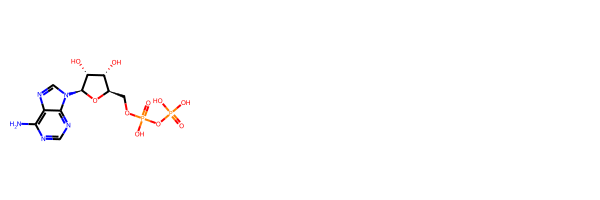

Predicting.. This will take a minute or so..

Prediction successful!

Result:



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
#@title Get prediction:
# prediction_type = "kcat" #@param ["kcat", "Km", "Ki"]
parameter = 'Ki' # @param ["kcat", "Km", "Ki"] {allow-input: true}
parameter = parameter.lower()

uniprot_id = "P04806" #@param {type:"string"}
#@markdown If you do not have a uniprot-id, enter some name (for eg: "enzyme1")
sequence = 'MVHLGPKKPQARKGSMADVPKELMDEIHQLEDMFTVDSETLRKVVKHFIDELNKGLTKKGGNIPMIPGWVMEFPTGKESGNYLAIDLGGTNLRVVLVKLSGNHTFDTTQSKYKLPHDMRTTKHQEELWSFIADSLKDFMVEQELLNTKDTLPLGFTFSYPASQNKINEGILQRWTKGFDIPNVEGHDVVPLLQNEISKRELPIEIVALINDTVGTLIASYYTDPETKMGVIFGTGVNGAFYDVVSDIEKLEGKLADDIPSNSPMAINCEYGSFDNEHLVLPRTKYDVAVDEQSPRPGQQAFEKMTSGYYLGELLRLVLLELNEKGLMLKDQDLSKLKQPYIMDTSYPARIEDDPFENLEDTDDIFQKDFGVKTTLPERKLIRRLCELIGTRAARLAVCGIAAICQKRGYKTGHIAADGSVYNKYPGFKEAAAKGLRDIYGWTGDASKDPITIVPAEDGSGAGAAVIAALSEKRIAEGKSLGIIGA' #@param {type:"string"}
SMILES = "C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)OP(=O)(O)O)O)O)N" #@param {type:"string"}

# Main execution
seq, smi = create_csv_sh(parameter, uniprot_id, sequence, SMILES)

if seq and smi:
    print('Predicting.. This will take a minute or so..\n')
    try:
        # Use subprocess to activate the environment and run the script
        command = (
            "source activate catpred && "
            "export PROTEIN_EMBED_USE_CPU=1 && "
            "chmod +x ./predict.sh && "
            "./predict.sh"
        )
        status = subprocess.call(command, shell=True, executable="/bin/bash")
        if status == 0:
            print('Prediction successful!\n')
            get_predictions(parameter, uniprot_id)
        else:
            print('Prediction failed!')
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
#@title Get BRENDA matches

# Find matches
input_smi = preprocess_reaction_smiles(smi)
seq = seq
parameter = parameter
matched_values = find_matches_brenda(brenda_df, input_smi, seq, parameter)

# Display matches
display_matches_brenda(matched_values, parameter)

Found 0 occurrences of input in BRENDA:


In [ ]:
#@title Get SABIO-RK matches

# Find matches
input_smi = preprocess_reaction_smiles(smi)
seq = seq
parameter = parameter
matched_values = find_matches_sabio(sabio_df, input_smi, seq, parameter)

# Display matches
display_matches_sabio(matched_values, parameter)

Found 0 occurrences of input in SABIO-RK:


## Helper codes


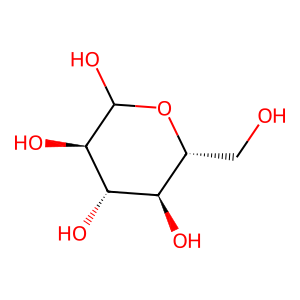
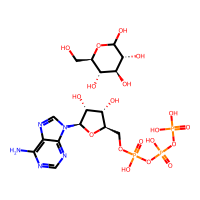

In [ ]:
#@title Helper to fetch SMILES strings of reactions using substrate SMILES
#@markdown This code takes as input an enzyme sequence and a substrate SMILES to
#@markdown find hits from BRENDA and SABIO-RK which match with the enzyme sequence
#@markdown and substrate SMILES and list its coreactants
# prediction_type = "kcat" #@param ["kcat", "Km", "Ki"]
parameter = parameter.lower()

import time
import pandas as pd
import numpy as np
from IPython.display import Image, display
from rdkit import Chem
from rdkit.Chem.Draw.IPythonConsole import ShowMols

sequence = 'MLDDRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ' #@param {type:"string"}
Substrate_SMILES = "C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O " #@param {type:"string"}

matched_seq = find_matches_brenda_seq(brenda_df, sequence)

from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, HTML

def mol_to_img_str(mol, size=(200, 200)):
    img = Draw.MolToImage(mol, size=size)
    import io
    import base64
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

def create_table_html(rows, headers):
    table_html = """
    <table style="border-collapse: collapse; width: 100%; margin-bottom: 20px;">
      <tr>
    """
    for header in headers:
        table_html += f'<th style="border: 1px solid black; padding: 8px; text-align: center;">{header}</th>'
    table_html += "</tr>"

    for row in rows:
        table_html += "<tr>"
        for cell in row:
            table_html += f'<td style="border: 1px solid black; padding: 8px; text-align: center;">{cell}</td>'
        table_html += "</tr>"

    table_html += "</table>"
    return table_html

# Assume this is your input SMILES for the query molecule
query_smiles = Substrate_SMILES
query_mol = Chem.MolFromSmiles(query_smiles)
query_img_str = mol_to_img_str(query_mol, size=(300, 300))

# Create query table
query_table = create_table_html([
    ["Query Molecule", "SMILES"],
    [f'<img src="data:image/png;base64,{query_img_str}" alt="Query Molecule">', query_smiles]
], ["", ""])

# Create matched reactions table
list_of_matched_rxns = list(set(matched_seq.reaction_smiles))
matched_rows = []

for i, rxn in enumerate(list_of_matched_rxns):
    reactant_smi = rxn.split('>>')[0]
    mol = Chem.MolFromSmiles(reactant_smi)
    img_str = mol_to_img_str(mol)

    matched_rows.append([
        str(i+1),
        f'<img src="data:image/png;base64,{img_str}" alt="Molecule {i+1}">',
        reactant_smi
    ])

matched_table = create_table_html(matched_rows, ["Index", "Reactants", "Concatenated reactants SMILES"])

# Combine both tables and display
full_html = f"""
<h2>Query Molecule</h2>
{query_table}
<h2>Matched Reactions</h2>
{matched_table}
"""

display(HTML(full_html))



In [10]:
import pandas as pd

In [12]:
batch_df=pd.read_csv('/content/petseqs.csv')

In [13]:
# ============================
# Batch kcat prediction script
# ============================

import os
import time
import pandas as pd
import numpy as np
from IPython.display import Image, display, Math
from rdkit import Chem
from rdkit.Chem.Draw.IPythonConsole import ShowMols
import subprocess

parameter = 'kcat'
parameter = parameter.lower()

# ----------------------------
# Updated helper functions
# ----------------------------

def create_csv_sh(parameter, uni, seq, smi):
    """Create input CSV + shell script for a single prediction."""
    try:
        mol = Chem.MolFromSmiles(smi)
        smi = Chem.MolToSmiles(mol)
    except:
        print(f"[{uni}] Invalid SMILES — skipping.")
        return None, None

    valid_aas = set('ACDEFGHIKLMNPQRSTVWY')
    if not set(seq).issubset(valid_aas):
        print(f"[{uni}] Invalid sequence — skipping.")
        return None, None

    if parameter == 'kcat' and '.' in smi:
        smi = '.'.join(sorted(smi.split('.')))

    csv_name = f'{uni}_{parameter}_input.csv'
    with open(csv_name, 'w') as f:
        f.write('name,sequence,SMILES,pdbpath\n')
        f.write(f'{uni},{seq},{smi},{uni}.pdb\n')

    sh_name = f'predict_{uni}.sh'
    with open(sh_name, 'w') as f:
        f.write(f'''
TEST_FILE_PREFIX={uni}_{parameter}
RECORDS_FILE=${{TEST_FILE_PREFIX}}.json.gz
CHECKPOINT_DIR=../pretrained/production/{parameter}/

python ./scripts/create_pdbrecords.py --data_file ${{TEST_FILE_PREFIX}}_input.csv --out_file ${{RECORDS_FILE}}
python predict.py --test_path ${{TEST_FILE_PREFIX}}_input.csv --preds_path ${{TEST_FILE_PREFIX}}_output.csv --checkpoint_dir $CHECKPOINT_DIR --uncertainty_method mve --smiles_column SMILES --individual_ensemble_predictions --protein_records_path $RECORDS_FILE
''')

    os.chmod(sh_name, 0o755)
    return csv_name, sh_name


def extract_prediction(parameter, uni):
    """Extract prediction + uncertainties from output CSV."""
    df = pd.read_csv(f'{uni}_{parameter}_output.csv')

    if parameter == 'kcat':
        target_col = 'log10kcat_max'
        unit = ' s^{-1}'
    elif parameter == 'km':
        target_col = 'log10km_mean'
        unit = ' mM'
    else:
        target_col = 'log10ki_mean'
        unit = ' mM'

    unc_col = f'{target_col}_mve_uncal_var'
    model_cols = [c for c in df.columns if c.startswith(target_col) and 'model_' in c]

    pred_log = df[target_col].iloc[0]
    pred_linear = 10 ** pred_log

    unc_total = np.sqrt(df[unc_col].iloc[0])
    model_outs = np.array([df[c].iloc[0] for c in model_cols])
    epi_unc = np.sqrt(np.var(model_outs))
    alea_unc = np.sqrt(max(0, unc_total**2 - epi_unc**2))

    return pred_linear, pred_log, unc_total, alea_unc, epi_unc, unit


# ============================
# Main batch loop
# ============================

results = []

for idx, row in batch_df.iterrows():
    seq = row['sequence']
    smi = row['Isomeric SMILES']
    uni = row.get("uniprot_id", f"batch_{idx}")

    print(f"\n=== Processing {uni} (row {idx}) ===")

    csv_file, sh_file = create_csv_sh(parameter, uni, seq, smi)
    if csv_file is None:
        continue

    print(f"Running prediction for {uni}...")
    command = (
        "source activate catpred && "
        "export PROTEIN_EMBED_USE_CPU=1 && "
        f"./{sh_file}"
    )
    status = subprocess.call(command, shell=True, executable="/bin/bash")

    if status != 0:
        print(f"[{uni}] Prediction failed.")
        continue

    pred_linear, pred_log, unc_total, alea_unc, epi_unc, unit = extract_prediction(parameter, uni)

    results.append({
        "row": idx,
        "id": uni,
        "sequence": seq,
        "SMILES": smi,
        "prediction": pred_linear,
        "log10_prediction": pred_log,
        "SD_total": unc_total,
        "SD_aleatoric": alea_unc,
        "SD_epistemic": epi_unc,
        "unit": unit
    })

results_df = pd.DataFrame(results)
print("\nBatch prediction complete.")
results_df



=== Processing batch_0 (row 0) ===
Running prediction for batch_0...

=== Processing batch_1 (row 1) ===
Running prediction for batch_1...

=== Processing batch_2 (row 2) ===
Running prediction for batch_2...

=== Processing batch_3 (row 3) ===
Running prediction for batch_3...

=== Processing batch_4 (row 4) ===
Running prediction for batch_4...

=== Processing batch_5 (row 5) ===
Running prediction for batch_5...

=== Processing batch_6 (row 6) ===
Running prediction for batch_6...

=== Processing batch_7 (row 7) ===
Running prediction for batch_7...

=== Processing batch_8 (row 8) ===
Running prediction for batch_8...

=== Processing batch_9 (row 9) ===
Running prediction for batch_9...

=== Processing batch_10 (row 10) ===
Running prediction for batch_10...

=== Processing batch_11 (row 11) ===
Running prediction for batch_11...

=== Processing batch_12 (row 12) ===
Running prediction for batch_12...

=== Processing batch_13 (row 13) ===
Running prediction for batch_13...

=== Pro

KeyboardInterrupt: 

In [14]:
import glob
import pandas as pd

parameter = "kcat"

files = sorted(glob.glob(f"*_{parameter}_output.csv"))
print(f"Found {len(files)} completed predictions.")

all_results = []

for f in files:
    df = pd.read_csv(f)
    uni = f.replace(f"_{parameter}_output.csv", "")

    # identify target column
    target_col = "log10kcat_max"
    unc_col = f"{target_col}_mve_uncal_var"
    model_cols = [c for c in df.columns if c.startswith(target_col) and "model_" in c]

    pred_log = df[target_col].iloc[0]
    pred_linear = 10 ** pred_log
    unc_total = (df[unc_col].iloc[0]) ** 0.5
    model_outs = df[model_cols].iloc[0].values
    epi_unc = model_outs.var() ** 0.5
    alea_unc = max(0, unc_total**2 - epi_unc**2) ** 0.5

    all_results.append({
        "id": uni,
        "log10_kcat": pred_log,
        "kcat": pred_linear,
        "SD_total": unc_total,
        "SD_aleatoric": alea_unc,
        "SD_epistemic": epi_unc
    })

results_df = pd.DataFrame(all_results)
results_df


Found 364 completed predictions.


,id,log10_kcat,kcat,SD_total,SD_aleatoric,SD_epistemic
0,P35557,1.903745,80.120729,0.357165,0.278078,0.224142
1,batch_0,0.526452,3.360875,0.939994,0.755163,0.559747
2,batch_100,0.546747,3.521658,0.961544,0.785236,0.554951
3,batch_101,0.543872,3.498422,0.960784,0.783930,0.555481
4,batch_102,0.548653,3.537149,0.958278,0.786245,0.547829
...,...,...,...,...,...,...
359,batch_96,0.504554,3.195612,0.946818,0.763475,0.559972
360,batch_97,0.528612,3.377632,0.945162,0.774374,0.541920
361,batch_98,0.544137,3.500552,0.943773,0.764764,0.553030
362,batch_99,0.530629,3.393351,0.958783,0.783027,0.553293


In [15]:
results_df.to_csv("kcat_partial_results.csv", index=False)


In [16]:
pwd

'/content/catpred'

In [17]:
from google.colab import files
files.download("kcat_partial_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
import glob
import pandas as pd
import numpy as np

parameter = "kcat"

# Load all completed output files
files = sorted(glob.glob(f"*_{parameter}_output.csv"))
print(f"Found {len(files)} completed predictions.")

records = []

for f in files:
    df = pd.read_csv(f)
    uni = f.replace(f"_{parameter}_output.csv", "")

    # Extract row index from "batch_123"
    if uni.startswith("batch_"):
        row_idx = int(uni.split("_")[1])
    else:
        # fallback if you used custom uniprot IDs
        row_idx = None

    # Identify target column
    target_col = "log10kcat_max"
    unc_col = f"{target_col}_mve_uncal_var"
    model_cols = [c for c in df.columns if c.startswith(target_col) and "model_" in c]

    pred_log = df[target_col].iloc[0]
    pred_linear = 10 ** pred_log
    unc_total = np.sqrt(df[unc_col].iloc[0])
    model_outs = df[model_cols].iloc[0].values
    epi_unc = np.sqrt(np.var(model_outs))
    alea_unc = np.sqrt(max(0, unc_total**2 - epi_unc**2))

    records.append({
        "id": uni,
        "row": row_idx,
        "log10_kcat": pred_log,
        "kcat": pred_linear,
        "SD_total": unc_total,
        "SD_aleatoric": alea_unc,
        "SD_epistemic": epi_unc
    })

results_df = pd.DataFrame(records)

# Merge with original batch_df to recover sequences + SMILES
merged = results_df.merge(
    batch_df,
    left_on="row",
    right_index=True,
    how="left"
)

merged


Found 364 completed predictions.


,id,row,log10_kcat,kcat,SD_total,SD_aleatoric,SD_epistemic,sequence,Isomeric SMILES
0,P35557,NaN,1.903745,80.120729,0.357165,0.278078,0.224142,NaN,NaN
1,batch_0,0.0,0.526452,3.360875,0.939994,0.755163,0.559747,AADNPYQRGPDPTNASIEAATGPFAAGTQPIVGASGFGGGQIYYPT...,OCCOCOC(=O)c1ccc(cc1)C(=O)OCCOCOC(=O)c2ccc(cc2...
2,batch_100,100.0,0.546747,3.521658,0.961544,0.785236,0.554951,AADNPYQRGPDPTNASIEAATGPFAVGTQPIVGASGFGGGQIYYPT...,OCCOCOC(=O)c1ccc(cc1)C(=O)OCCOCOC(=O)c2ccc(cc2...
3,batch_101,101.0,0.543872,3.498422,0.960784,0.783930,0.555481,AADNPYQRGPDPTNASIEAATGPFAVGTQPIVGASGFGGGQIYYPT...,OCCOCOC(=O)c1ccc(cc1)C(=O)OCCOCOC(=O)c2ccc(cc2...
4,batch_102,102.0,0.548653,3.537149,0.958278,0.786245,0.547829,AADNPYQRGPDPTNASIEAATGPFAVGTQPIVGASGFGGGQIYYPT...,OCCOCOC(=O)c1ccc(cc1)C(=O)OCCOCOC(=O)c2ccc(cc2...
...,...,...,...,...,...,...,...,...,...
359,batch_96,96.0,0.504554,3.195612,0.946818,0.763475,0.559972,AADNPYQRGPDPTNASIEAATGPFAVGTQPIVGASGFGGGQIYYPT...,OCCOCOC(=O)c1ccc(cc1)C(=O)OCCOCOC(=O)c2ccc(cc2...
360,batch_97,97.0,0.528612,3.377632,0.945162,0.774374,0.541920,AADNPYQRGPDPTNASIEAATGPFAVGTQPIVGASGFGGGQIYYPT...,OCCOCOC(=O)c1ccc(cc1)C(=O)OCCOCOC(=O)c2ccc(cc2...
361,batch_98,98.0,0.544137,3.500552,0.943773,0.764764,0.553030,AADNPYQRGPDPTNASIEAATGPFAVGTQPIVGASGFGGGQIYYPT...,OCCOCOC(=O)c1ccc(cc1)C(=O)OCCOCOC(=O)c2ccc(cc2...
362,batch_99,99.0,0.530629,3.393351,0.958783,0.783027,0.553293,AADNPYQRGPDPTNASIEAATGPFAVGTQPIVGASGFGGGQIYYPT...,OCCOCOC(=O)c1ccc(cc1)C(=O)OCCOCOC(=O)c2ccc(cc2...


In [19]:
merged.to_csv("kcat_partial_with_sequences.csv", index=False)

from google.colab import files
files.download("kcat_partial_with_sequences.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>